(example_4)=
# Example 4: Learning causal coupling

Author contribution: Lina Walkowiak

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/Example_3_Multi_armed_bandit.ipynb)

In [86]:
import sys
from IPython.utils import io
if 'google.colab' in sys.modules:

  with io.capture_output() as captured:
      ! pip install pyhgf watermark



In [87]:
%load_ext autoreload
%autoreload 2

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import pandas as pd
from jax import jit, vjp
from jax.tree_util import Partial
from pyhgf import load_data
from pyhgf.math import binary_surprise
from pyhgf.model.network import Network
from pyhgf.utils import beliefs_propagation
from pyhgf.typing import AdjacencyLists
from pytensor.graph import Apply, Op
from pyhgf.updates.causal_functions import calculate_mutual_information, calculate_surd, calculate_prediction_difference, get_coupling_strength, update_coupling_strength_prediction_error, update_coupling_strength_surd, set_coupling_strength


np.random.seed(123)
plt.rcParams["figure.constrained_layout.use"] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction
In this notebook, we implement a model that incorporates causal coupling. 
First, the theory of the causal couplign mechanisms will be outlined before then implementing the functions on simulated data. We simulate two time series, where one has a causal influence on the other, differeing in its strength. The model then takes two time series as input, which are provided to the two continuous state nodes that are causally coupled. The strength of this coupling is dynamically updated based on the provided observations. 



##  Methods for Updating of Causal Coupling

### Mutual Information and SURD Decomposition

Using mutual information (MI), we quantify the shared information between nodes:
   - Parent-Child MI: $$ I(\text{Parent}; \text{Child}) = H(\text{Parent}) + H(\text{Child}) - H(\text{Parent}, \text{Child}) $$
   - Parent-Parent MI: Similarly, it represents the shared information between parents.
   - Self Entropy: $ H(\text{Child}) $, representing the child's uncertainty.

We then decompose MI into SURD terms:
   - Redundant: Shared information across parents.
   - Unique: Exclusive information from each parent.
   - Synergistic: Joint contribution when parents are considered together. (currently, it is considering all parents, not indidvidual pairs.)
   - Leak: Remaining uncertainty in the child.

The coupling strength is then updated based on the parent's components constituation. 
Weighted Scoring: Each type of information is assigned a weight, with unique and synergistic information increasing the coupling, while redundant decreases it (what about leak?)

A sigmoid function is used for more a smooth of a adjustment to the coupling strength. The coupling is then clipped to stay within [0,1].




### Sigmoid-Adjusted Prediction Difference

This method updates coupling strengths by assessing the difference in PE between parent and child.
- Prediction Difference:
$$ \Delta \text{PE} = \text{PE}_{\text{child}} - (\text{coupling strength} \times \text{PE}_{\text{parent}}) 
   $$
- Reliability Adjustment: Using a sigmoid function, the adjustment factor is calculated as:
$$
\text{Adjustment} = \frac{\eta}{1 + e^{-(\frac{\Delta \text{PE}}{\text{PE}_{\text{child}} + 1e-8} - 1)}}
$$
- Updated Coupling Strength: Coupling is updated and clipped within [0, 1].

This works on the logic that only reliable parents' influences should lead to strengthened coupling, while unreliable influences weaken it.

## Simulating a data set


We model two binary time series, Series A and Series B, where the causal influence of A on B varies over time. We establish different levels of causal strenggth: 
high, medium, and low. These affect the likelihood of B given the state of A. 


In [88]:
# Define contingencies
high, medium, low = 0.8, 0.5, 0.2

# Stable contingencies: Each level (low, medium, high) repeats for a block of 40 time steps
stable_contingencies = np.array([low, medium, high]).repeat(50)

# Alternating contingencies: Each level repeats for 10 time steps, cycling 6 times for each level
alternating_contingencies = np.tile(np.array([low, medium, high]).repeat(10), 5)

# Combine both stable and alternating contingencies
causal_influence_sequence = np.concatenate([stable_contingencies, alternating_contingencies])

# Generate binary series independently
n_samples = len(causal_influence_sequence)
series_A = np.random.choice([0, 1], size=n_samples) 

# generate binary series with influence from the series A dependent on the strength of the current block
series_B = np.zeros(n_samples)
for i in range(n_samples):
    causal_effect = causal_influence_sequence[i]
    # Select causal effect and inverse of causal effect based on whether A is 0 or 1 
    prob_B_given_A = causal_effect if series_A[i] == 1 else (1 - causal_effect)
    series_B[i] = np.random.choice([0, 1], p=[1 - prob_B_given_A, prob_B_given_A])

/var/folders/sr/t35nvgpn1m9d3bl1dbwrj4300000gn/T/ipykernel_866/1309979409.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


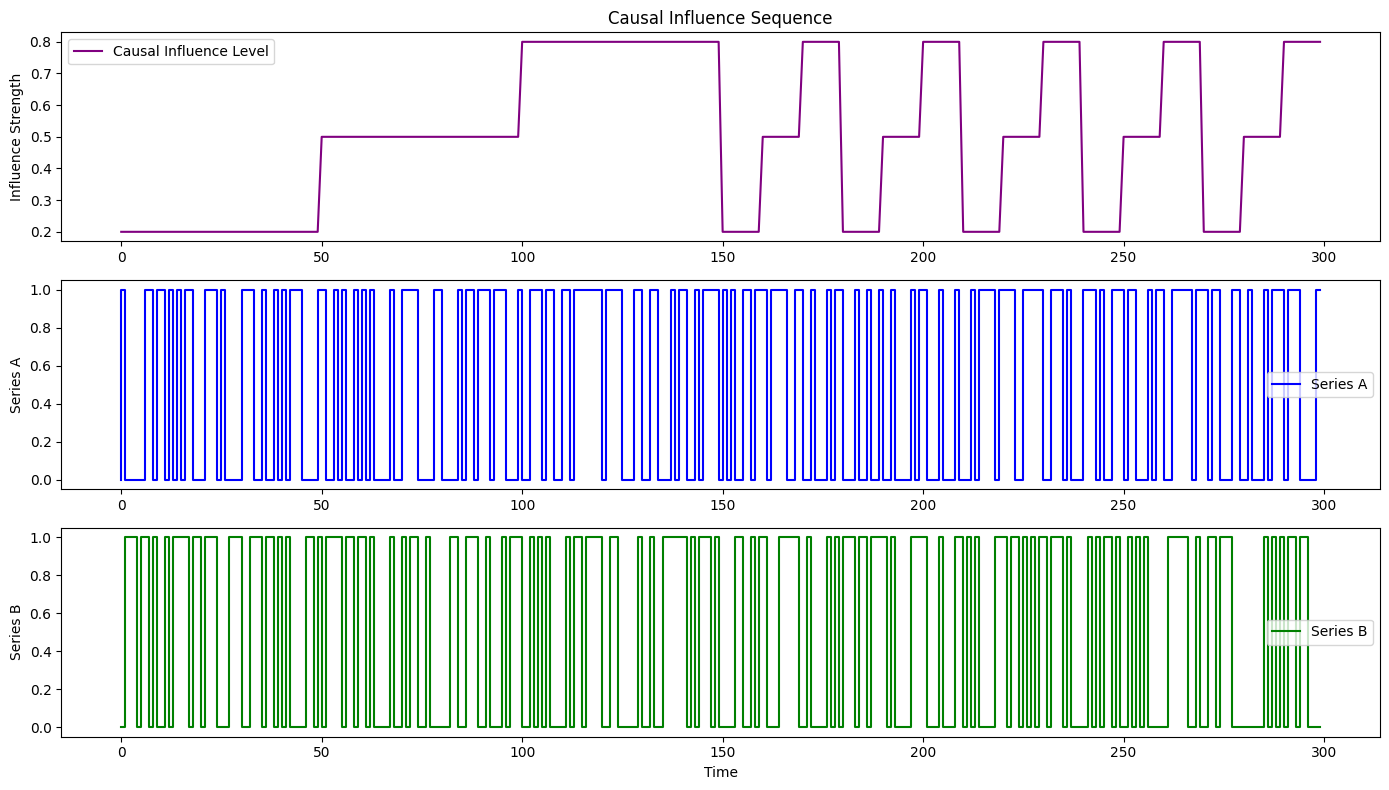

In [89]:
# Plot the time series and contingency blocks 
plt.figure(figsize=(14, 8))

plt.subplot(3, 1, 1)
plt.plot(causal_influence_sequence, color='purple', label='Causal Influence Level')
plt.title("Causal Influence Sequence")
plt.ylabel("Influence Strength")
plt.legend()

plt.subplot(3, 1, 2)
plt.step(range(n_samples), series_A, color='blue', label='Series A')
plt.ylabel("Series A")
plt.legend()

plt.subplot(3, 1, 3)
plt.step(range(n_samples), series_B, color='green', label='Series B')
plt.xlabel("Time")
plt.ylabel("Series B")
plt.legend()

plt.tight_layout()
plt.show()

### Testing functions
- Mutual information of child node and parents
- SURD values of child and parent
- approximate 'counterfactual' prediction error without parent's influence
- updated prediction error based on learning rate 


In [102]:
timeserie = load_data("continuous")
two_levels_continuous_hgf = (
    Network()
    .add_nodes(precision=1e4)
    .add_nodes(precision=1e4, mean=timeserie[0], value_children=([0],[0.5]))
    .add_nodes(precision=1e4, mean=timeserie[0], value_children=([1],[0.9]))
    .add_nodes(precision=1e4,mean = timeserie[0], value_children=([1],[0.2]))
    .add_nodes(precision=1e4,mean=timeserie[0],  value_children=([1],[0.5]) )
)
 
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(input_data=timeserie)

array([<Axes: title={'left': 'State Node 4'}, ylabel='$\\mu_{4}$'>,
       <Axes: title={'left': 'State Node 3'}, ylabel='$\\mu_{3}$'>,
       <Axes: title={'left': 'State Node 2'}, ylabel='$\\mu_{2}$'>,
       <Axes: title={'left': 'State Node 1'}, ylabel='$\\mu_{1}$'>,
       <Axes: title={'left': 'Continuous Input Node 0'}, xlabel='Time', ylabel='$\\mu_{0}$'>],
      dtype=object)

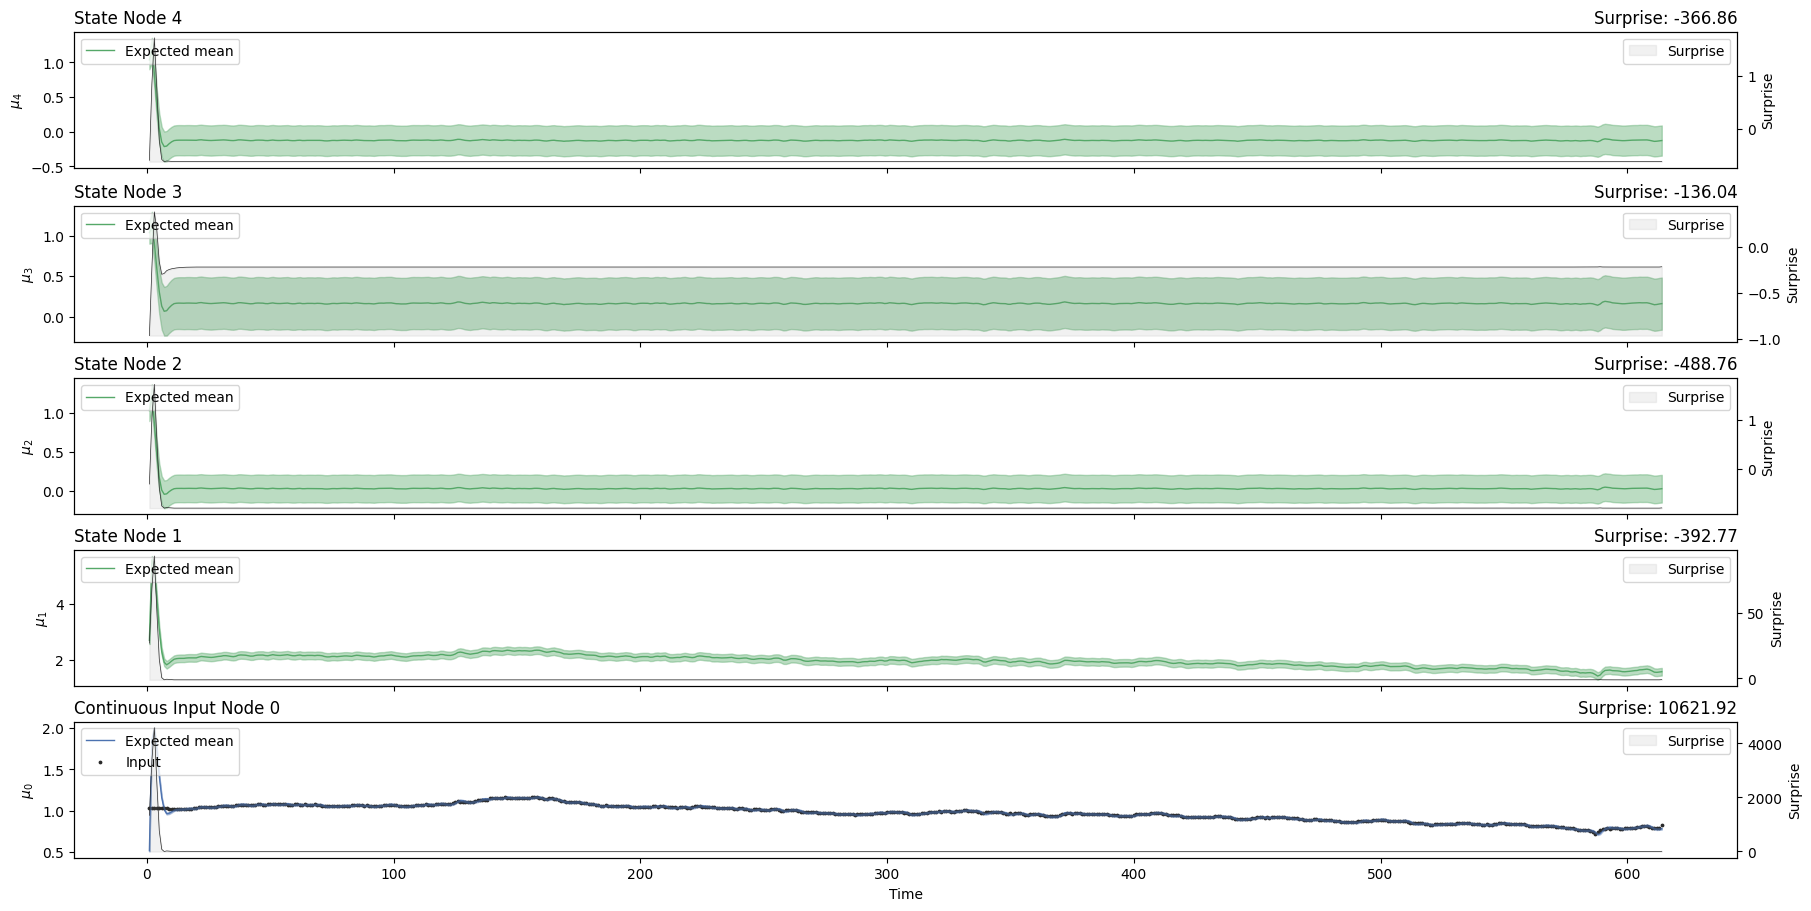

In [103]:
two_levels_continuous_hgf.plot_network()
two_levels_continuous_hgf.plot_trajectories()

In [96]:
MI_dict = calculate_mutual_information(two_levels_continuous_hgf, 1)
SURD = calculate_surd(MI_dict, 1)
update_coupling_strength_surd(two_levels_continuous_hgf, 1)


{2: 0.5084435796192048, 3: 0.23022912031391032, 4: 0.5302291840753877}

In [97]:
# Exmaple of PE function usage
counterfactual_error = calculate_prediction_difference(
    two_levels_continuous_hgf, child_idx = 1
)
# And Upadate strength based on PE
updated_strength = update_coupling_strength_prediction_error(
    two_levels_continuous_hgf, child_idx=1, learning_rate = 0.05
)


In [94]:
# Set a new coupling strength between child node 1 and parent node 2
set_coupling_strength(two_levels_continuous_hgf, child_idx=1, parent_idx=2, new_strength=0.5)


## System configuration

In [95]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Fri Nov 08 2024

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

pyhgf : 0.0.0
jax   : 0.4.35
jaxlib: 0.4.35

pymc      : 5.17.0
numpy     : 1.26.0
matplotlib: 3.9.2
pytensor  : 2.25.5
IPython   : 8.29.0
arviz     : 0.20.0
pandas    : 2.2.3
seaborn   : 0.13.2
jax       : 0.4.35
sys       : 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
pyhgf     : 0.0.0

Watermark: 2.5.0

